# Hybrid Merge-Insertion Sort

### Library Imports

In [27]:
import random, time, gc, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hybrid Merge-Insertion Sort Class

In [2]:
class HybridMISort:
    # Main sorting function
    @staticmethod
    def sort(array, S=32):
        counter = [0]
        HybridMISort.mergesort(array, 0, len(array) - 1, S, counter)
        return counter[0]
    
    #Counter functions for key comparisons
    @staticmethod
    def lessequal(a, b, counter):
        counter[0] += 1
        return a <= b
    
    @staticmethod
    def greater(a, b, counter):
        counter[0] += 1
        return a > b
    
    # Algorithms
    @staticmethod
    def mergesort(a, left, right, S, counter):
        if S > 0 and right - left + 1 <= S:
            HybridMISort.insertionsort(a, left, right, counter)
            return
        if left >= right:
            return
        mid = (left + right) // 2
        HybridMISort.mergesort(a, left, mid, S, counter)
        HybridMISort.mergesort(a, mid + 1, right, S, counter)
        HybridMISort.merge(a, left, mid, right, counter)
    
    @staticmethod
    def merge(array, left, mid, right, counter):
        n1 = mid - left + 1
        n2 = right - mid
        L = array[left:left + n1]
        R = array[mid + 1:mid + 1 + n2]
        i = j = 0
        k = left
        while i < n1 and j < n2:
            if HybridMISort.lessequal(L[i], R[j], counter): # if L[i] <= R[j]:
                array[k] = L[i]
                i += 1
            else:
                array[k] = R[j]
                j += 1
            k += 1
        while i < n1:
            array[k] = L[i]
            i += 1
            k += 1
        while j < n2:
            array[k] = R[j]
            j += 1
            k += 1

    @staticmethod
    def insertionsort(array, left, right, counter):
        for i in range(left + 1, right + 1):
            key = array[i]
            j = i - 1
            while j >= left and HybridMISort.greater(array[j], key, counter): # array[j] > key
                array[j + 1] = array[j]
                j -= 1
            array[j + 1] = key

## Array Generators

### Random Array Generator

In [3]:
def randarr(size=1000, seed=42):
    rng = random.Random(seed)
    return rng.sample(range(1, size + 1), k=size)

### Best Case Array Generator

In [4]:
def bestcase(size=1000):
    return list(range(1, size+1))

### Worst Case MergeSort Array Generator

In [5]:
def worstmerges(size=1000):
    a = list(range(1, size+1))
    def rec(xs):
        if len(xs) <= 1:
            return xs
        left  = rec(xs[1::2])
        right = rec(xs[0::2])
        return left + right
    return rec(a)

### Worst Case HybridSort Array Generator

In [6]:
def worst_case_hybrid(size, S):
    arr = worstmerges(size)
    if S > 1:
        for i in range(0, size, S):
            j = min(i+S, size)
            arr[i:j] = sorted(arr[i:j], reverse=True)
    return arr

## Experiment Functions

### Single Run Function

In [7]:
def singlerun(size, S, case="random", seed=42):
    if case == "random":
        a = randarr(size, seed)
    elif case == "best":
        a = bestcase(size)
    elif case == "worst":
        a = worst_case_hybrid(size, S)
    else:
        raise ValueError("case must be 'random', 'best', or 'worst'")

    t0 = time.perf_counter()
    comps = HybridMISort.sort(a, S=S)
    t1 = time.perf_counter()
    return comps, (t1 - t0)


### Data Collection for different array sizes with fixed S

In [18]:
def multiarray(S=32, trials=5, case="random", seed=42):
    arraysize = [10**k for k in range(3, 7)]
    rows = []
    for array in arraysize:
        comps_list, time_list = [], []
        for r in range(trials):
            comps, secs = singlerun(array, S, case=case, seed=seed+r)
            comps_list.append(comps)
            time_list.append(secs)
            gc.collect() # Clear memory otherwise crash
        rows.append({
            "Array": array,
            "S": S,
            "case": case,
            "comparisons_avg": np.mean(comps_list),
            "time_s_avg": np.mean(time_list)
        })
    return pd.DataFrame(rows)

### Data Collection for different array sizes with varying S

In [30]:
def gridsearch_array_S(trials=1, case="random", seed=42):
    S_values = range(1, 33)
    frames = [multiarray(S=S, trials=trials, case=case, seed=seed) for S in S_values]
    return pd.concat(frames, ignore_index=True)

## Experiments

###
i. With the value of S fixed, plot the number of key comparisons over different sizes of the input list n. Compare your empirical results with your theoretical analysis of the time complexity.

In [20]:
df_i = multiarray()
df_i

,Array,S,case,comparisons_avg,time_s_avg
0,1000,32,random,13398.4,0.002512
1,10000,32,random,143301.4,0.028380
2,100000,32,random,1862005.4,0.360069
3,1000000,32,random,23187460.4,4.903726


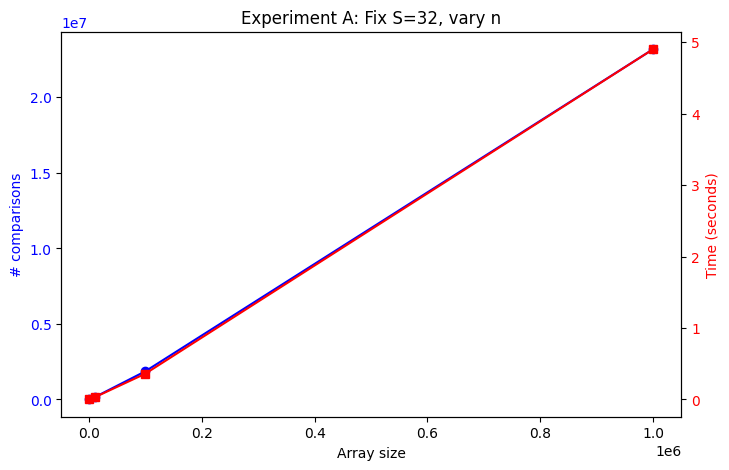

In [67]:
plt.figure(figsize=(8,5))
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot comparisons_avg on left y-axis
ax1.plot(df_i["Array"], df_i["comparisons_avg"], marker="o", color="b", label="Hybrid comparisons")
ax1.set_xlabel("Array size")
ax1.set_ylabel("# comparisons", color="b")
ax1.tick_params(axis='y', labelcolor="b")

# Plot time_s_avg on right y-axis
ax2.plot(df_i["Array"], df_i["time_s_avg"], marker="s", color="r", label="Time (s)")
ax2.set_ylabel("Time (seconds)", color="r")
ax2.tick_params(axis='y', labelcolor="r")

plt.title("Experiment A: Fix S=32, vary n")
plt.show()

###
ii. With the input size n fixed, plot the number of key comparisons over
different values of S. Compare your empirical results with your
theoretical analysis of the time complexity.


and


iii. Using different sizes of input datasets, study how to determine an
optimal value of S for the best performance of this hybrid algorithm.

In [ ]:
df_ii = gridsearch_array_S(trials=5, case="random", seed=42)
df_ii

In [70]:
def plot_comparisons_vs_S(df, array=10**3):
    df_case = df[df["Array"] == array]  # Filter for the given array size
    grouped_comps = df_case.groupby("S")["comparisons_avg"].mean()
    grouped_time = df_case.groupby("S")["time_s_avg"].mean()

    plt.figure(figsize=(8,5))
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot comparisons_avg on left y-axis
    ax1.plot(grouped_comps.index, grouped_comps.values, marker="o", color="b", label="Comparisons")
    ax1.set_xlabel("S (Insertion Sort Threshold)")
    ax1.set_ylabel("Average # Comparisons", color="b")
    ax1.tick_params(axis='y', labelcolor="b")

    # Plot time_s_avg on right y-axis
    ax2.plot(grouped_time.index, grouped_time.values, marker="s", color="r", label="Time (s)")
    ax2.set_ylabel("Average Time (seconds)", color="r")
    ax2.tick_params(axis='y', labelcolor="r")

    plt.title(f"Comparisons and Time vs S for Array='{array}'")
    plt.grid(True)
    plt.show()

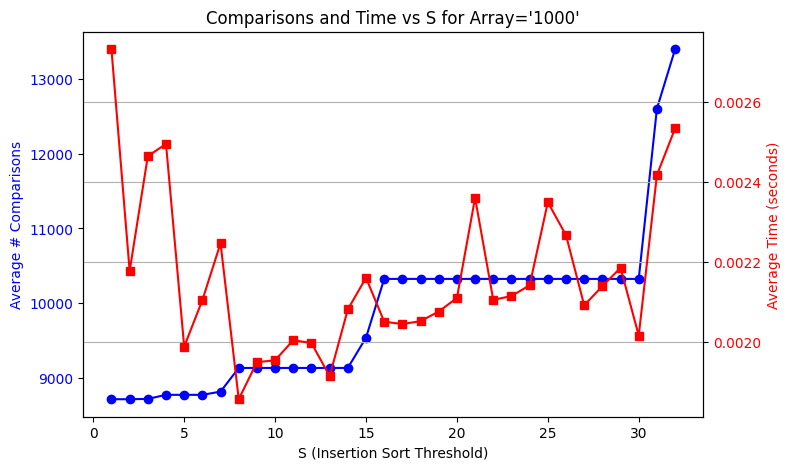

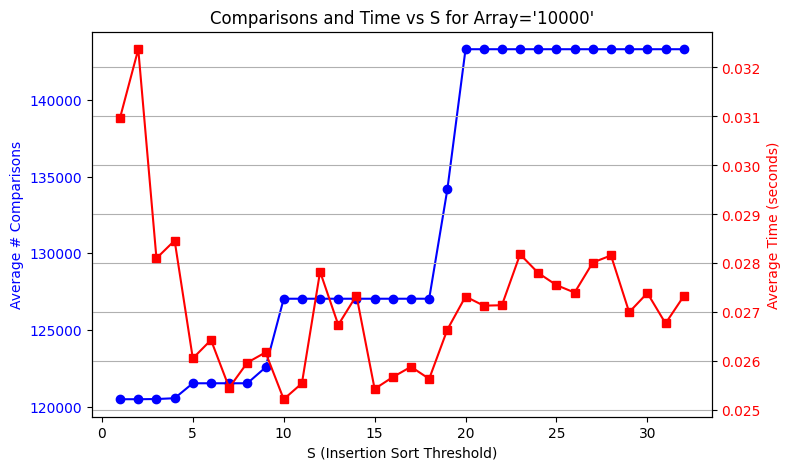

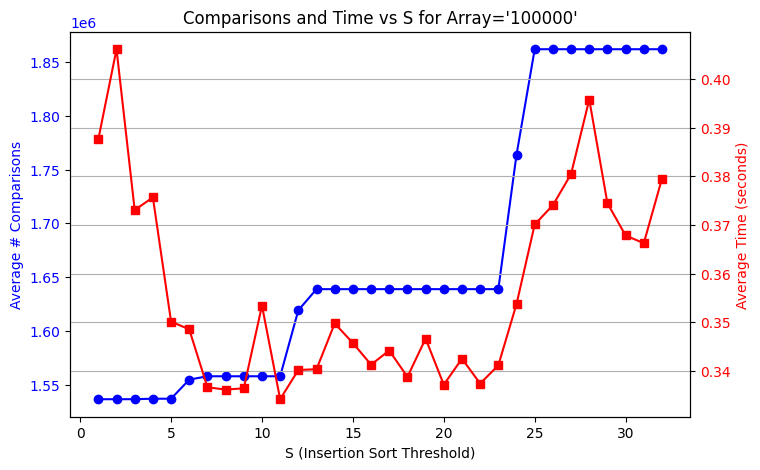

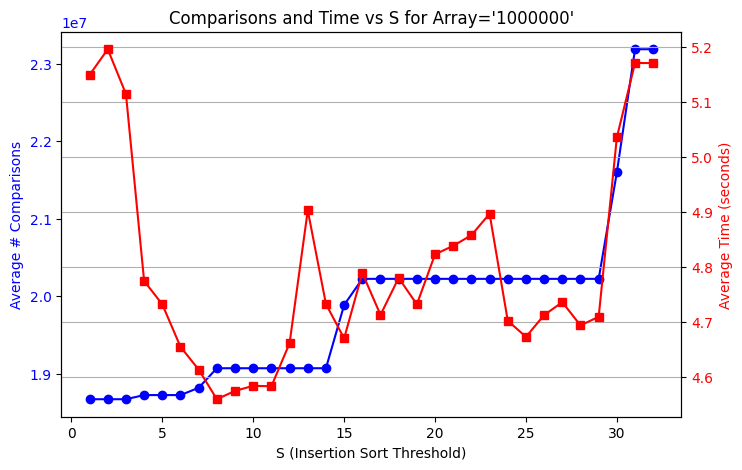

In [72]:
plot_comparisons_vs_S(df_ii, array=10**3)
plot_comparisons_vs_S(df_ii, array=10**4)
plot_comparisons_vs_S(df_ii, array=10**5)
plot_comparisons_vs_S(df_ii, array=10**6)

###
iv. Implement the original version of Mergesort (as learnt in lecture). Compare its performance against the above hybrid algorithm in terms of the number of key comparisons and CPU times on the dataset with 10 million integers. You can use the optimal value of S obtained in (c) for this task.

In [26]:
df_iv = multiarray(S=0)
df_iv

,Array,S,case,comparisons_avg,time_s_avg
0,1000,0,random,8715.6,0.002476
1,10000,0,random,120484.4,0.030114
2,100000,0,random,1536387.4,0.402472
3,1000000,0,random,18673679.4,4.918522


   trial  hybrid_comparisons  hybrid_time_s  original_comparisons  \
0      1           221107722      86.302343             220099204   

   original_time_s  
0         90.79788  


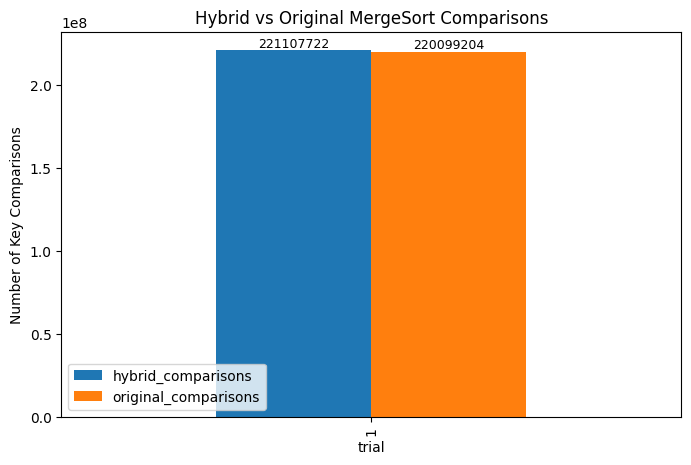

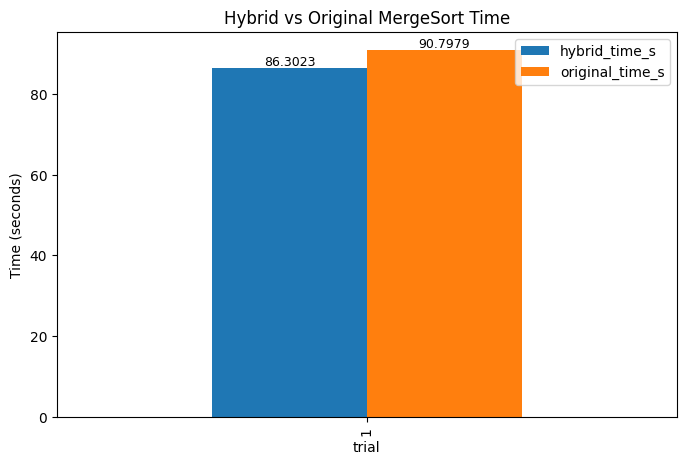

In [5]:
# -*- coding: utf-8 -*-
import random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Config / Parameters
# -----------------------------
ARRAY_SIZE = 10000000   # Change this to test different sizes
OPTIMAL_S = 8
TRIALS = 1
SEED = 42

# -----------------------------
# Hybrid Merge-Insertion Sort
# -----------------------------
class HybridMISort:
    @staticmethod
    def sort(array, S=OPTIMAL_S):
        counter = [0]
        HybridMISort.mergesort(array, 0, len(array)-1, S, counter)
        return counter[0]
    
    @staticmethod
    def lessequal(a, b, counter):
        counter[0] += 1
        return a <= b
    
    @staticmethod
    def greater(a, b, counter):
        counter[0] += 1
        return a > b
    
    @staticmethod
    def mergesort(a, left, right, S, counter):
        if S > 0 and right - left + 1 <= S:
            HybridMISort.insertionsort(a, left, right, counter)
            return
        if left >= right:
            return
        mid = (left + right)//2
        HybridMISort.mergesort(a, left, mid, S, counter)
        HybridMISort.mergesort(a, mid+1, right, S, counter)
        HybridMISort.merge(a, left, mid, right, counter)
    
    @staticmethod
    def merge(array, left, mid, right, counter):
        n1, n2 = mid-left+1, right-mid
        L, R = array[left:left+n1], array[mid+1:mid+1+n2]
        i = j = 0
        k = left
        while i < n1 and j < n2:
            if HybridMISort.lessequal(L[i], R[j], counter):
                array[k] = L[i]; i += 1
            else:
                array[k] = R[j]; j += 1
            k += 1
        while i < n1: array[k] = L[i]; i += 1; k += 1
        while j < n2: array[k] = R[j]; j += 1; k += 1
    
    @staticmethod
    def insertionsort(array, left, right, counter):
        for i in range(left+1, right+1):
            key = array[i]
            j = i-1
            while j >= left and HybridMISort.greater(array[j], key, counter):
                array[j+1] = array[j]; j -= 1
            array[j+1] = key

# -----------------------------
# Original MergeSort
# -----------------------------
class OriginalMergeSort:
    @staticmethod
    def sort(array):
        counter = [0]
        OriginalMergeSort.mergesort(array, 0, len(array)-1, counter)
        return counter[0]
    
    @staticmethod
    def lessequal(a, b, counter):
        counter[0] += 1
        return a <= b
    
    @staticmethod
    def mergesort(a, left, right, counter):
        if left >= right: return
        mid = (left+right)//2
        OriginalMergeSort.mergesort(a, left, mid, counter)
        OriginalMergeSort.mergesort(a, mid+1, right, counter)
        OriginalMergeSort.merge(a, left, mid, right, counter)
    
    @staticmethod
    def merge(array, left, mid, right, counter):
        n1, n2 = mid-left+1, right-mid
        L, R = array[left:left+n1], array[mid+1:mid+1+n2]
        i = j = 0
        k = left
        while i < n1 and j < n2:
            if OriginalMergeSort.lessequal(L[i], R[j], counter):
                array[k] = L[i]; i += 1
            else:
                array[k] = R[j]; j += 1
            k += 1
        while i < n1: array[k] = L[i]; i += 1; k += 1
        while j < n2: array[k] = R[j]; j += 1; k += 1

# -----------------------------
# Array generator
# -----------------------------
def randarr(size=ARRAY_SIZE, seed=SEED):
    rng = random.Random(seed)
    return rng.sample(range(1, size+1), k=size)

# -----------------------------
# Comparison function
# -----------------------------
def compare_hybrid_vs_original(size=ARRAY_SIZE, optimal_S=OPTIMAL_S, trials=TRIALS):
    results = []
    for trial in range(trials):
        arr_hybrid = randarr(size, seed=SEED+trial)
        arr_original = arr_hybrid.copy()
        
        t0 = time.perf_counter()
        comps_hybrid = HybridMISort.sort(arr_hybrid, S=optimal_S)
        t1 = time.perf_counter()
        time_hybrid = t1 - t0
        
        t0 = time.perf_counter()
        comps_original = OriginalMergeSort.sort(arr_original)
        t1 = time.perf_counter()
        time_original = t1 - t0
        
        results.append({
            'trial': trial+1,
            'hybrid_comparisons': comps_hybrid,
            'hybrid_time_s': time_hybrid,
            'original_comparisons': comps_original,
            'original_time_s': time_original
        })
    return pd.DataFrame(results)

# -----------------------------
# Run comparison
# -----------------------------
df_comparison = compare_hybrid_vs_original()
print(df_comparison)

# -----------------------------
# Plot comparisons with values on top
# -----------------------------
ax = df_comparison.plot(
    x='trial', 
    y=['hybrid_comparisons', 'original_comparisons'], 
    kind='bar', 
    figsize=(8,5)
)
plt.ylabel("Number of Key Comparisons")
plt.title("Hybrid vs Original MergeSort Comparisons")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', 
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9)
plt.show()

# -----------------------------
# Plot time with values on top
# -----------------------------
ax = df_comparison.plot(
    x='trial', 
    y=['hybrid_time_s', 'original_time_s'], 
    kind='bar', 
    figsize=(8,5)
)
plt.ylabel("Time (seconds)")
plt.title("Hybrid vs Original MergeSort Time")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', 
                (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9)
plt.show()
